## Image stitching trial

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


image1 = cv2.imread("tiles/tile_0001_x409_y0.jpg", 
                    #cv2.IMREAD_GRAYSCALE
                    )
image2 = cv2.imread("tiles/tile_0002_x818_y0.jpg", 
                    #cv2.IMREAD_GRAYSCALE
                    )

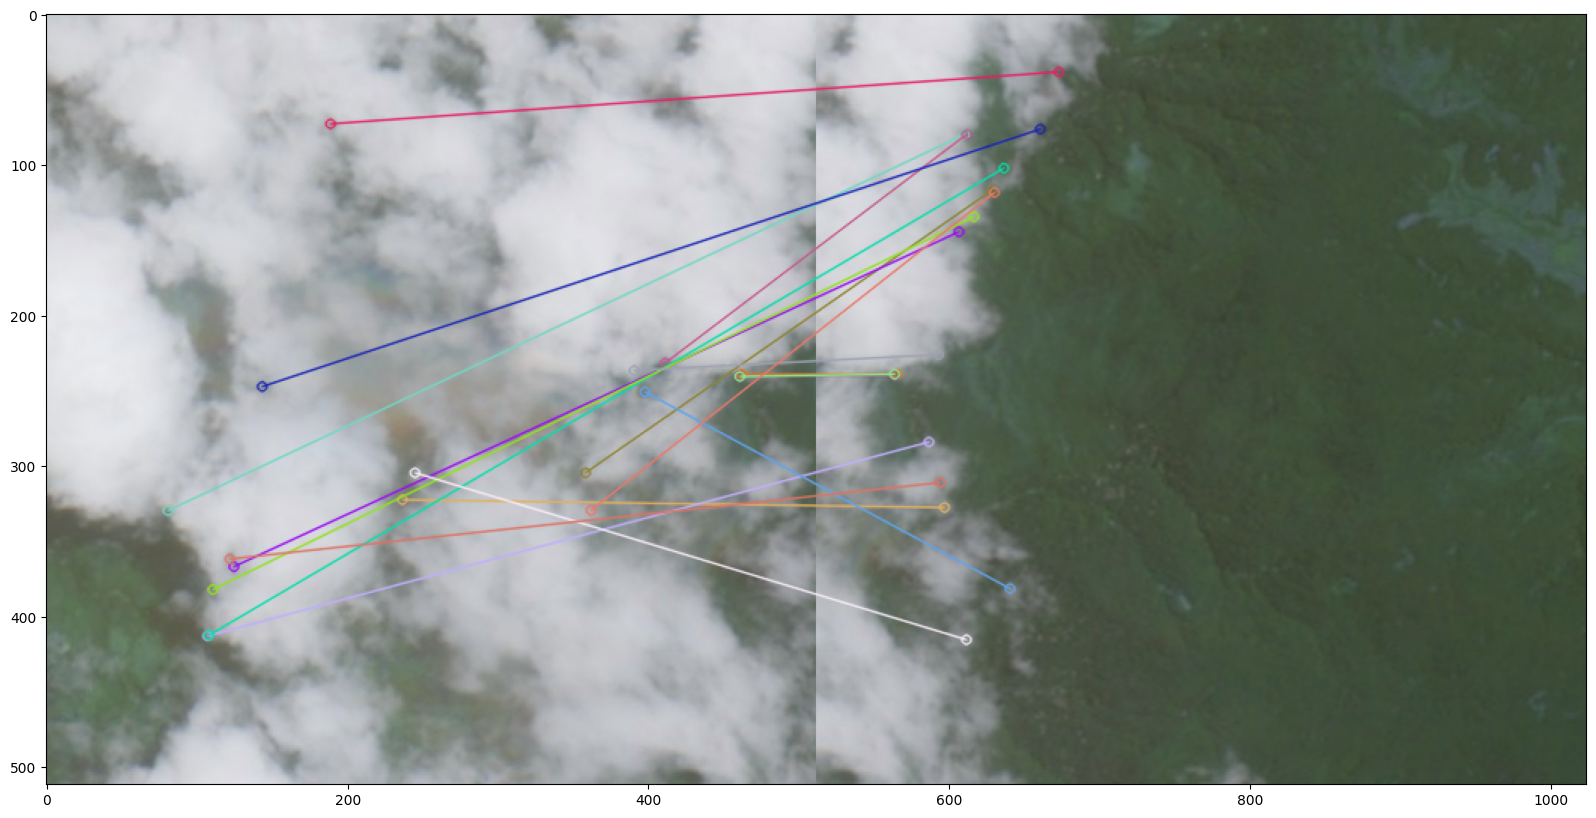

In [12]:
# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=2000)  # Play with nfeatures

# Find keypoints and descriptors
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
raw_matches = bf.match(des1, des2)

# Sort matches by distance
raw_matches = sorted(raw_matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(
    image1, kp1, image2, kp2, raw_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(img_matches)
plt.show()

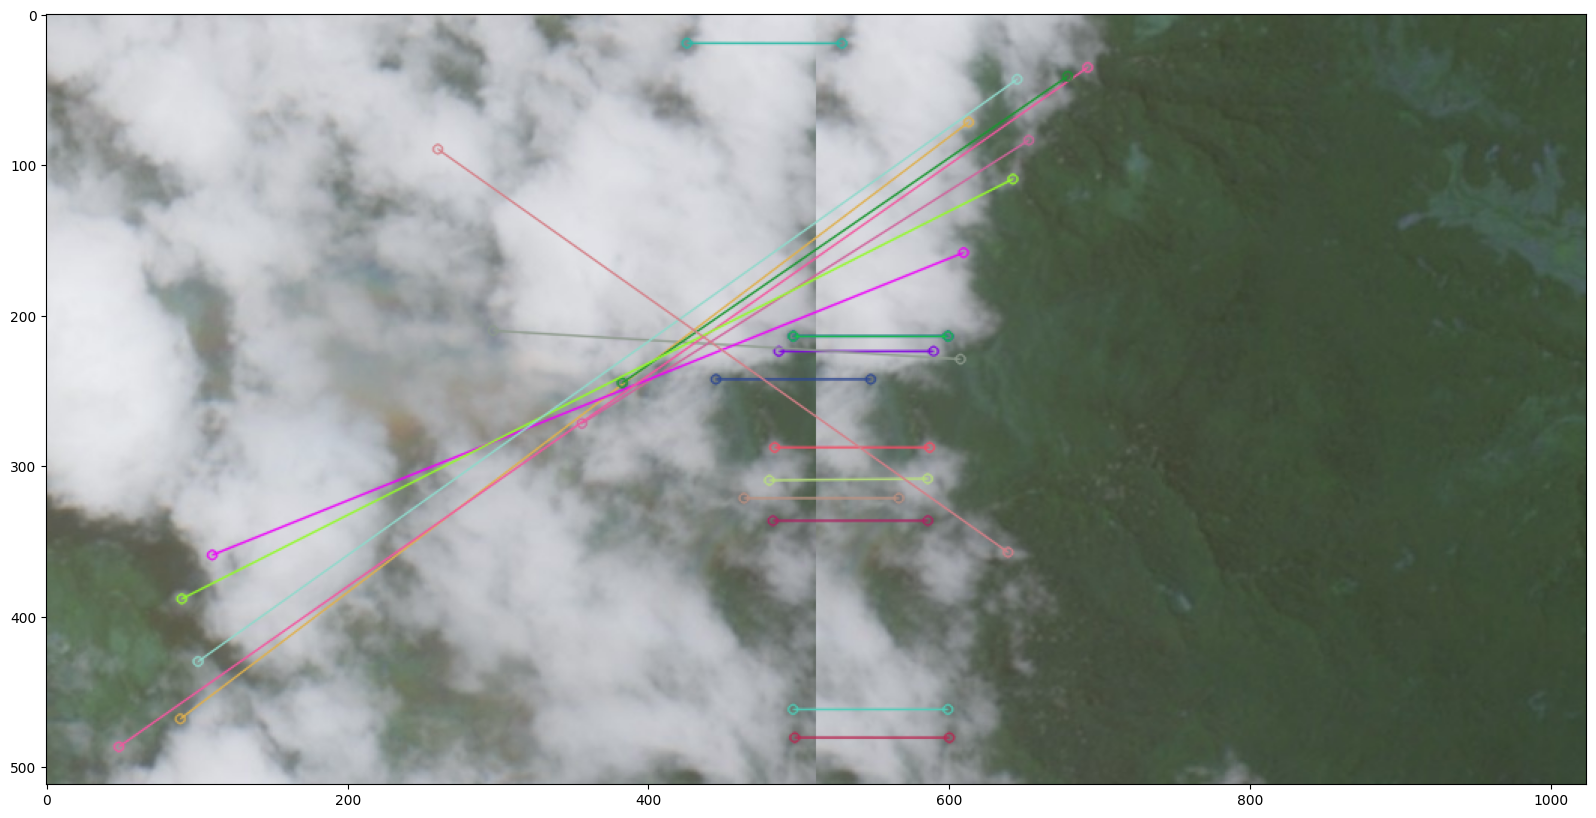

In [13]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(image1, None)
kp2, des2 = sift.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
raw_matches = bf.match(des1, des2)

# Sort matches by distance
raw_matches = sorted(raw_matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(
    image1, kp1, image2, kp2, raw_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10))
plt.imshow(img_matches)
plt.show()

In [14]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in raw_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in raw_matches]).reshape(-1, 1, 2)

# Find homography matrix and inlier mask
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # Play with the ransacReprojThreshold value (5.0)
# Use the mask to select only the inlier matches
good_matches = [raw_matches[i] for i, val in enumerate(mask) if val.ravel() == 1]

# Draw matches
matched_image = cv2.drawMatches(image1, kp1, image2, kp2, good_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10))
plt.imshow(matched_image)
plt.show()

In [15]:
H

array([[ 1.16209693e+00, -4.11274503e-03, -4.75310580e+02],
       [ 7.51171428e-02,  1.12460018e+00, -3.16125094e+01],
       [ 3.27783288e-04, -5.54950377e-05,  1.00000000e+00]])

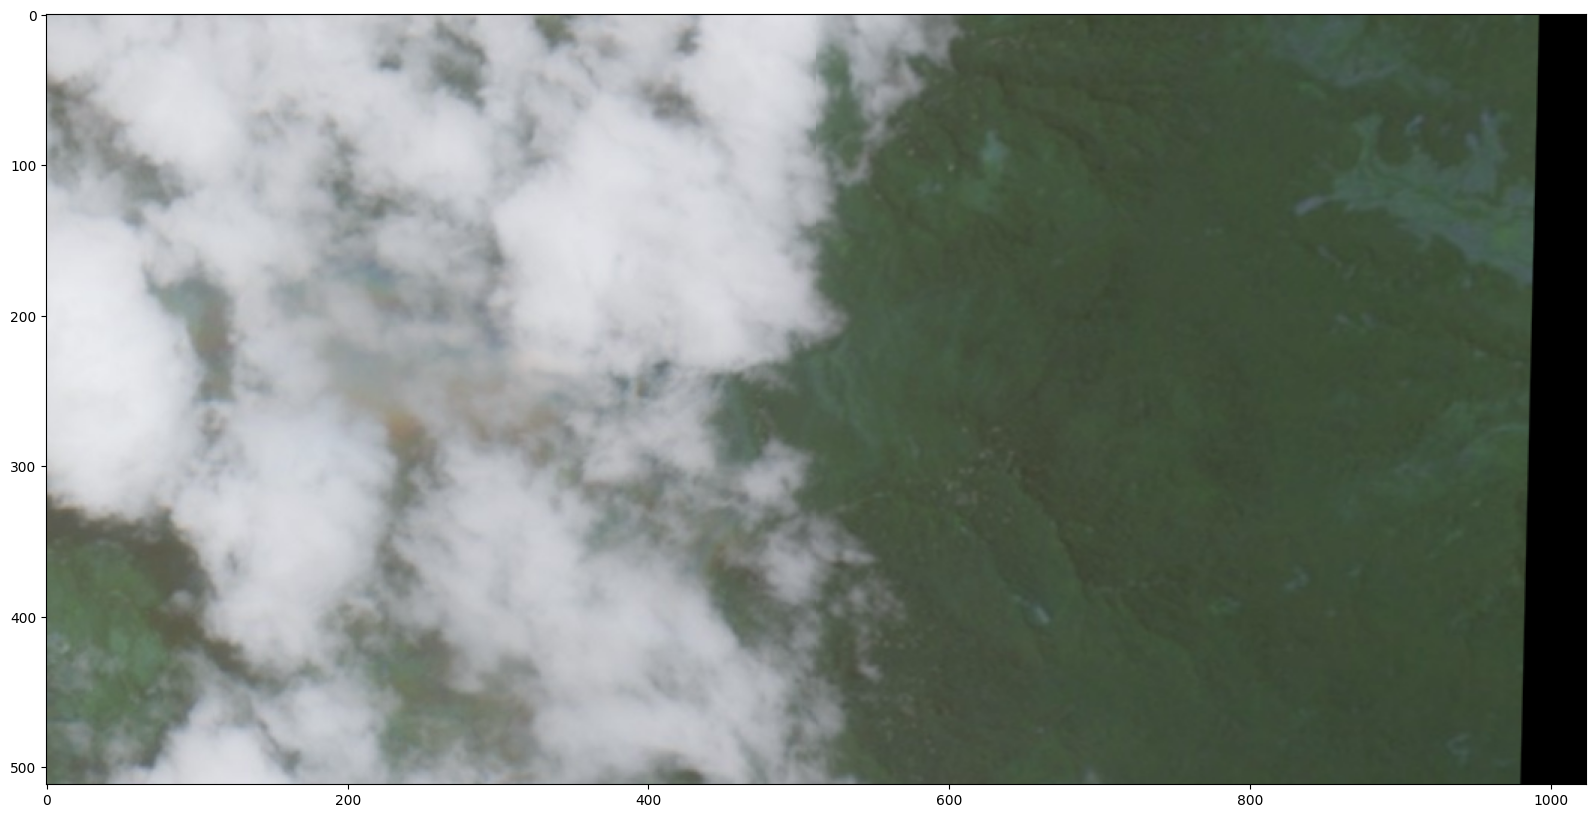

In [18]:
# Get the height and width of both images
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]

H_inv = np.linalg.inv(H)

img2_warped = cv2.warpPerspective(image2, H_inv, (w1 + w2, h1))
img2_warped[0:h1, 0:w1] = image1
plt.figure(figsize=(20,10))
plt.imshow(img2_warped)
plt.show()  

In [23]:
# Get the height and width of both images
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]

# Get the canvas size for the warped image
corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(corners, H)
x_min = warped_corners[:, 0, 0].min()
y_min = warped_corners[:, 0, 1].min()
x_max = warped_corners[:, 0, 0].max()
y_max = warped_corners[:, 0, 1].max()
offset_x = max(0, -x_min)
offset_y = max(0, -y_min)

# Calculate proper canvas size
warped_width = int(x_max - x_min + offset_x)
warped_height = int(y_max - y_min + offset_y)
canvas_width = max(warped_width, w2 + int(offset_x))
canvas_height = max(warped_height, h2 + int(offset_y))
print(warped_width, w2 + int(offset_x))
print(warped_height, h2 + int(offset_y))
translation_matrix = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]])
combined = translation_matrix @ H
img1_warped = cv2.warpPerspective(image1, combined, (canvas_width, canvas_height))

# Place Image 2 at the correct offset position
end_x = min(int(offset_x) + w2, canvas_width)
end_y = min(int(offset_y) + h2, canvas_height)

img1_warped[int(offset_y):end_y, int(offset_x):end_x] = image2[:end_y-int(offset_y), :end_x-int(offset_x)]
plt.figure(figsize=(20,10))
plt.imshow(img1_warped)
plt.show()

1085 1003
623 543


In [9]:
# Get the height and width of both images
h1, w1 = image1.shape[:2]

# Get the canvas size for the warped image
corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(corners, H)
x_min = warped_corners[:, 0, 0].min()
y_min = warped_corners[:, 0, 1].min()
x_max = warped_corners[:, 0, 0].max()
y_max = warped_corners[:, 0, 1].max()
print(x_min, y_min, x_max, y_max)
translation_offset = (-x_min, -y_min)

-491.37805 -31.612509 103.19126 560.0971


In [10]:
# Get the height and width of both images
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]

# Get the canvas size for the warped image
corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(corners, H_inv)

print(warped_corners.shape)
# Find the min and max coordinates
x_min = min(0, warped_corners[:, 0].min())
x_max = max(w1, warped_corners[:, 0].max())
y_min = min(0, warped_corners[:, 1].min())
y_max = max(h1, warped_corners[:, 1].max())

# Calculate translation distance to avoid negative coordinates
tx = -x_min
ty = -y_min

# Create translation matrix
translation_matrix = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])

# Combine translation with homography
M = translation_matrix @ H_inv

# Warp the image
warped_image = cv2.warpPerspective(image2, M, (int(x_max - x_min), int(y_max - y_min)))

# Create a copy of the warped image as our canvas
result = warped_image.copy()

# Calculate where to place image_left
y1, y2 = int(ty), int(ty + h1)
x1, x2 = int(tx), int(tx + w1)

# Place image_left on the canvas
result[y1:y2, x1:x2] = image2

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

(4, 1, 2)


IndexError: index 1 is out of bounds for axis 1 with size 1